In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

# 这是一个自定义数据集类，用于加载叶子图像数据。
class LeafDataset(Dataset):
    # csv_path: 图像文件名和标签的CSV文件路径, 如csv_path='train.csv',
    # img_dir: 图像文件所在的目录, img_dir='images',
    # is_test: 是否为测试集标志（默认为False）
    def __init__(self, csv_path, img_dir, transform=None, is_test=False):
        self.df = pd.read_csv(csv_path)  # 读取CSV文件到DataFrame
        self.img_dir = img_dir # 存储图像目录
        self.transform = transform
        self.is_test = is_test


        # 初始化标签编码器
        if not self.is_test:
            self.le = LabelEncoder() # 初始化一个标签编码器对象
            # 对DataFrame(df)中的label列进行编码，将文本标签（如"healthy"、"diseased"）转换为数字（如0、1）。
            self.labels = self.le.fit_transform(self.df['label'])
        else:
            self.labels = None
#  创建一个返回数据集大小（样本数量）的__len__方法
    def __len__(self):
        # 必须返回整数类型
        return len(self.df)

# 获取单个样本
    def __getitem__(self, idx):
        # self.df 是一个Pandas DataFrame，存储了所有样本的信息（每行是一个样本，包含image列和label列）
        # .iloc[idx]：通过整数索引idx选择第idx行的数据
        # ['image']：从该行中提取image列的值（即图像文件名，如"leaf_001.jpg"）
        img_name = self.df.iloc[idx]['image']
        # self.img_dir：是图像存储的根目录（例如"./data/train/"）。
        # os.path.join()：将目录路径和文件名拼接成完整路径（例如"./data/train/leaf_001.jpg"）
        img_path = os.path.join(self.img_dir, img_name)

        # 添加文件存在性检查
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"图片文件 {img_path} 不存在！")

        #  加载图像并转换为RGB格式
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image) # 应用指定的图像变换, 这里没有变换

        # 训练集：返回图像和对应的标签（转换为PyTorch张量）
        if not self.is_test:
            return image, torch.tensor(self.labels[idx], dtype=torch.long)
        # 测试集：只返回图像
        else:
            return image

标签编码器（LabelEncoder）是scikit-learn库中的一个工具，属于sklearn.preprocessing模块。它的主要功能是将文本形式的类别标签转换为数值形式，以便机器学习算法能够处理
例如，将类别标签 ["猫", "狗", "鸟"] 编码为 [0, 1, 2]
许多机器学习模型（如神经网络、决策树、SVM等）要求输入是数值型数据，标签编码器可以帮助我们处理类别型标签。

In [ ]:
import torchvision.models as models

# 从torchvision.models加载预训练的ResNet-18模型。
def get_model(num_classes):
    model = models.resnet18(pretrained=True)  # pretrained=True：使用在ImageNet数据集上预训练的权重（包含1000类分类能力）
    # model.fc.in_features：获取原全连接层的输入维度（ResNet-18中是512）。
    # num_classes：自定义任务的类别数（通过train_df['label'].unique()计算）。
    # 作用：将模型输出维度从1000改为自定义类别数（我们这个网络需要的）
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model
# 这个函数获取模型, 并根据分类任务的类别数改造模型, 所以在执行这个函数之前, 我们要获取分类任务的类别总数

# 创建模型（需要先获取类别数量）
train_df = pd.read_csv('train.csv')
# 从训练集的CSV文件中统计标签的唯一值数量（即标签有几类）
num_classes = len(train_df['label'].unique())
model = get_model(num_classes) # 调用getmodel函数

d:\AAAdownload\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AAAdownload\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# torch.cuda.is_available()：检查是否可用NVIDIA GPU。
# model.to(device)：将模型参数和计算迁移到GPU/CPU，加速训练。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# 多分类任务的标准损失函数
criterion = torch.nn.CrossEntropyLoss()
# model.parameters()获取所有可训练参数，lr=0.001为学习率
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



# 通过自定义LeafDataset类加载所有训练数据
full_train_dataset = LeafDataset(
    # 设置csv_path与img_dir
    csv_path='train.csv',
    img_dir='images',
)

# 2. 拆分训练集和验证集（80%训练，20%验证）
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # 固定随机种子保证可重复性
)

# 3. 创建DataLoader
train_loader = DataLoader(
    train_dataset, # 训练数据
    batch_size=32, # 每批加载32个样本
    shuffle=True,  # 每个epoch打乱数据，避免模型记忆顺序
    num_workers=4, # 4个子进程并行加载数据，加速IO
    pin_memory=True # 将数据预加载到GPU显存（若可用），减少传输延迟
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  # 验证集不需要打乱
    num_workers=4,
    pin_memory=True
)



Epoch 1/10: 100%|████████████████████████| 574/574 [03:07<00:00,  3.05it/s, loss=0.7516, acc=57.68%]



Epoch 1 Summary: Loss: 1.4137 | Acc: 57.68%



Epoch 2/10: 100%|████████████████████████| 574/574 [02:06<00:00,  4.52it/s, loss=0.4396, acc=73.94%]



Epoch 2 Summary: Loss: 0.8268 | Acc: 73.94%



Epoch 3/10: 100%|████████████████████████| 574/574 [02:29<00:00,  3.83it/s, loss=0.3133, acc=80.90%]



Epoch 3 Summary: Loss: 0.5893 | Acc: 80.90%



Epoch 4/10: 100%|████████████████████████| 574/574 [02:42<00:00,  3.54it/s, loss=0.2382, acc=85.33%]



Epoch 4 Summary: Loss: 0.4480 | Acc: 85.33%



Epoch 5/10: 100%|████████████████████████| 574/574 [02:35<00:00,  3.69it/s, loss=0.1925, acc=87.88%]



Epoch 5 Summary: Loss: 0.3621 | Acc: 87.88%



Epoch 6/10: 100%|████████████████████████| 574/574 [02:35<00:00,  3.70it/s, loss=0.1655, acc=89.39%]



Epoch 6 Summary: Loss: 0.3112 | Acc: 89.39%



Epoch 7/10: 100%|████████████████████████| 574/574 [02:34<00:00,  3.72it/s, loss=0.1418, acc=90.80%]



Epoch 7 Summary: Loss: 0.2668 | Acc: 90.80%



Epoch 8/10: 100%|████████████████████████| 574/574 [02:37<00:00,  3.65it/s, loss=0.1329, acc=91.53%]



Epoch 8 Summary: Loss: 0.2499 | Acc: 91.53%



Epoch 9/10: 100%|████████████████████████| 574/574 [02:34<00:00,  3.72it/s, loss=0.1099, acc=92.98%]



Epoch 9 Summary: Loss: 0.2066 | Acc: 92.98%



Epoch 10/10: 100%|███████████████████████| 574/574 [02:31<00:00,  3.80it/s, loss=0.1038, acc=93.30%]



Epoch 10 Summary: Loss: 0.1952 | Acc: 93.30%



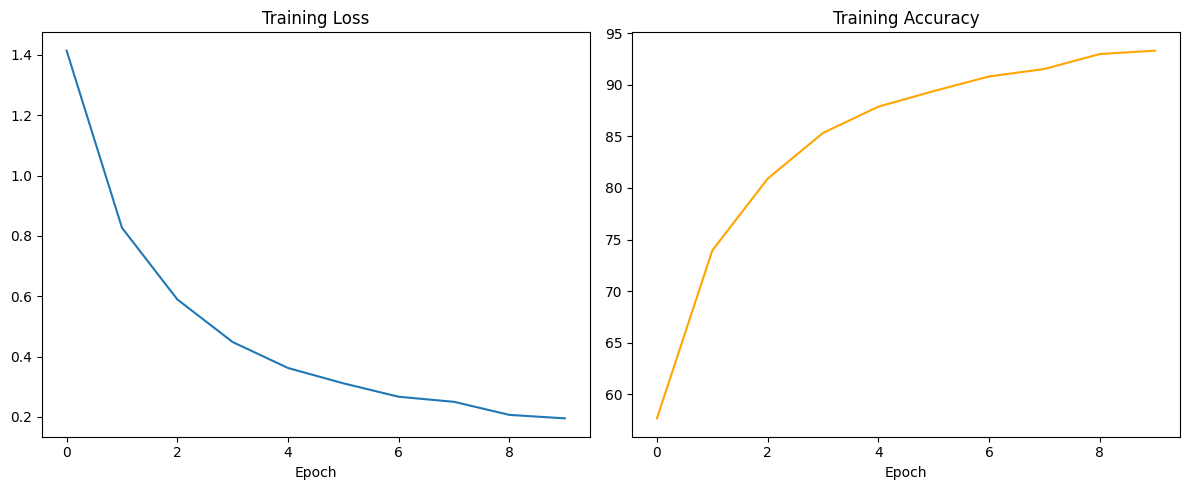

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # 新增导入

# 自动检测GPU并优先使用，显著加速训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# 交叉熵损失，适合多分类任务
criterion = torch.nn.CrossEntropyLoss()
# Adam优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 创建训练DataLoader（保持不变）
train_dataset = LeafDataset(
    csv_path='train.csv',
    img_dir='',
    transform=transforms.Compose([
        transforms.Resize(256), # 调整图像大小
        transforms.RandomHorizontalFlip(), # 数据增强：随机水平翻转
        transforms.ToTensor(), # 转为Tensor格式
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet标准化
    ])
)
# 每批32个样本，打乱顺序（shuffle=True）防止模型记忆顺序
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化记录列表（保持不变）
train_losses = []
train_accuracies = []

# 训练循环（添加进度条）
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用tqdm包装数据加载器
    # 通过tqdm库实时显示训练进度
    progress_bar = tqdm(train_loader,
                        desc=f'Epoch {epoch+1}/{10}',
                        ncols=100,  # 进度条宽度
                        postfix={'loss': '?', 'acc': '?'})  # 初始化显示指标

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 统计指标
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 实时更新进度条显示
        progress_bar.set_postfix({
            'loss': f'{running_loss/(total/len(labels)):.4f}',  # 当前平均损失
            'acc': f'{100*correct/total:.2f}%'  # 当前准确率
        })

    # 计算epoch指标
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # 记录指标
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # 打印epoch摘要（与进度条分开显示）
    print(f'\nEpoch {epoch+1} Summary: '
          f'Loss: {epoch_loss:.4f} | '
          f'Acc: {epoch_acc:.2f}%\n')

# 绘图部分保持不变
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# 测试集预处理
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 创建测试Dataset（is_test=True）
test_dataset = LeafDataset(
    csv_path='test.csv',
    img_dir='',
    transform=test_transform,
    is_test=True
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

将模型切换为评估模式的一些​关键影响：
关闭Dropout层（如果模型有）
固定BatchNorm层的均值和方差统计量（使用训练阶段计算的运行估计值）
确保推理过程的一致性

In [ ]:
# 模型测试阶段的核心流程，主要完成对测试集的预测、结果解码和保存
# 将模型切换为评估模式
model.eval()
all_preds = []

# 禁用梯度计算, 不跟踪计算图的梯度信息, 节省显存占用
with torch.no_grad():
    for images in test_loader:  # ​数据加载: 测试集只有图像，没有标签
        images = images.to(device) # 设备转移
        outputs = model(images) # 运行模型进行前向传播
        _, preds = torch.max(outputs, 1)  # 获取预测类别索引, 返回元组：(最大值, 索引)
        all_preds.extend(preds.cpu().numpy()) # 将预测结果转移到CPU并转为numpy数组

# 将预测的整数索引转换为原始标签名称
label_encoder = train_dataset.le  # 使用训练集的LabelEncoder
predicted_labels = label_encoder.inverse_transform(all_preds)

# 读取test.csv并添加预测结果
test_df = pd.read_csv('test.csv') # 读取原始测试集CSV
test_df['predicted_label'] = predicted_labels # 新增predicted_label列存储预测结果

# 保存为新的CSV文件
test_df.to_csv('test_with_predictions.csv', index=False)